## Timeseries classification using CNNs

### *Pol Roca Llaberia*

In this notebook we will implement the architecture for a CNN that will serve as a classifier. We will apply it to a timeseries dataset consisting of recordings from 6 different speakers, with the goal of predicting which voice produced each recording.

Although timeseries problems are usually approached with autoregressive models (e.g. RNNs), it will be easier to employ a classifier CNN since this dataset comes in a very clean form, containing series of all the same length (60 samples) already separated with only the interesting part, and also because there is no order between them.

In [1]:
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os

## Read and prepare the dataset

In [2]:
DATA_DIR='data_section3'

In [3]:
X = []
y = []
yi = 0
labels = os.listdir(DATA_DIR)

for folder in labels:
    for recording in os.listdir(os.path.join(DATA_DIR, folder)):
        fname = os.path.join(DATA_DIR, folder, recording)
        X.append(np.loadtxt(fname))
        y.append(yi)
    yi += 1

X = np.array(X)
X = X[..., None]  # formal shape 
y = np.array(y)
num_classes = yi

In [4]:
print(X.shape)
print(y.shape)
print('labels:', labels)
print('encoded labels:', np.unique(y))

(2268, 60, 1)
(2268,)
labels: ['wx01', 'wp02', 'wx02', 'wp01', 'wp21', 'wp22']
encoded labels: [0 1 2 3 4 5]


We standardize the data computing the z-score (assuming a gaussian distribution of the observations). Take into account that even though we have structured the instances as having 60 columns, these actually represent the same feature mesured 60 times, so the statistics have to be computed globally.

In [5]:
X = (X - X.mean()) / X.std()

## Visualize the data

Here we can visualize one timeseries example (the mean) per each class in the dataset.

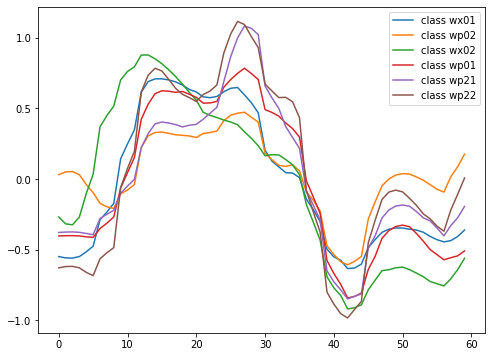

In [6]:
classes = np.unique(y)

plt.figure(figsize=(8, 6))
for i, c in enumerate(classes):
    class_mean = X[y == c].mean(axis=0)
    plt.plot(class_mean, label="class " + labels[i])
    
plt.legend(loc="best")
plt.show()
plt.close()

## Define model architecture

In [7]:
def make_model(input_shape, output_shape):
    model = keras.models.Sequential([
        layers.Conv1D(filters=64, kernel_size=3, kernel_initializer='he_uniform', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPool1D(strides=2),

        layers.Conv1D(filters=128, kernel_size=3, kernel_initializer='he_uniform', padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPool1D(strides=2),
        
        layers.Conv1D(filters=128, kernel_size=3, kernel_initializer='he_uniform', padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.GlobalMaxPooling1D(),
        # layers.Dropout(0.2),
        layers.Dense(output_shape, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=4e-4)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

model = make_model(input_shape=X.shape[1:], output_shape=num_classes)
model.save_weights('base_weights.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60, 64)            256       
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 64)            256       
_________________________________________________________________
re_lu (ReLU)                 (None, 60, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 128)           24704     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 128)           512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 30, 128)           0

## Evaluate model

The next cell performs a 10-fold cross-validation of the model with randomly shuffled and stratified data. Notice that we load the weights of the initial model everytime, to ensure the only thing changing at each fold is the instances the very same model sees.

In [8]:
skf = StratifiedKFold(n_splits=10, shuffle=True)

results = []
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model.load_weights('base_weights.h5')

    history = model.fit(
        X_train,
        y_train,
        epochs=80,
        batch_size=64,
        validation_data=(X_test, y_test),
        verbose=1)

    y_pred = model.predict(X_test).argmax(axis=1)
 
    results.append((
        history.history['val_accuracy'][-1],  # accuracy
        history.history,                      # loss curves
        confusion_matrix(y_test, y_pred)))    # confusion matrix  

2/32 [==============================] - 0s 13ms/step - loss: 0.0373 - accuracy: 1.0000 - val_loss: 0.0494 - val_accuracy: 1.0000
Epoch 21/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0327 - accuracy: 1.0000 - val_loss: 0.0421 - val_accuracy: 1.0000
Epoch 22/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0301 - accuracy: 1.0000 - val_loss: 0.0386 - val_accuracy: 1.0000
Epoch 23/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0269 - accuracy: 1.0000 - val_loss: 0.0351 - val_accuracy: 1.0000
Epoch 24/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0254 - accuracy: 1.0000 - val_loss: 0.0328 - val_accuracy: 1.0000
Epoch 25/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0230 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 1.0000
Epoch 26/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0213 - accuracy: 1.0000 - val_loss: 0.0266 - val_accuracy: 1.0000
Epoch 27/80
32/32 [

## Compute cross-validation accuracy

In [9]:
all_acc = [r[0] for r in results]
for i, acc in enumerate(all_acc):
    print(f'Fold {i} - accuracy: {acc}')

cv_acc = np.mean(all_acc)
stdev_acc = np.std(all_acc)
print('\nCV accuracy:', round(cv_acc, 4))
print('      stdev:', round(stdev_acc, 4))

Fold 0 - accuracy: 1.0
Fold 1 - accuracy: 1.0
Fold 2 - accuracy: 1.0
Fold 3 - accuracy: 1.0
Fold 4 - accuracy: 1.0
Fold 5 - accuracy: 1.0
Fold 6 - accuracy: 1.0
Fold 7 - accuracy: 1.0
Fold 8 - accuracy: 1.0
Fold 9 - accuracy: 1.0

CV accuracy: 1.0
      stdev: 0.0


## Plot best model's training evolution

For visualization purposes, we will analyze the best perfoming model out of all. (Yes, in this case, there is no best)

In [10]:
best_result = max(results, key=lambda r: r[0])

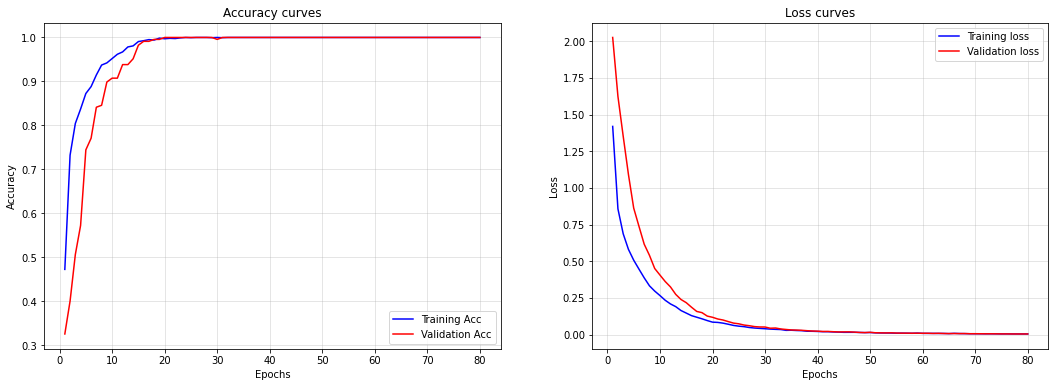

In [11]:
def plot_result(history):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # plot accuracy
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    epochs = range(1, len(acc)+1)

    ax = axes[0]
    ax.plot(epochs, acc, 'b', label='Training Acc')
    ax.plot(epochs, val_acc, 'r', label='Validation Acc')
    ax.set_title('Accuracy curves')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.grid(alpha=0.4)
    ax.legend()

    # plot validation loss
    loss = history['loss']
    val_loss = history['val_loss']

    ax = axes[1]
    ax.plot(epochs, loss, 'b', label='Training loss')
    ax.plot(epochs, val_loss, 'r', label='Validation loss')
    ax.set_title('Loss curves')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.grid(alpha=0.4)
    ax.legend()
    plt.show()

plot_result(best_result[1])

As we can see, the model achieves a perfect accuracy pretty fast. In general, after training and testing different architectures I consider this a rather easy task since in most cases the results were almost perfect.

However, results were never strictly perfect at the beginning. In at least one of the folds, every model I tried got stuck into a local minimum with an accuracy of 0.9868, preventing the CV accuracy to be exactly 1.0.

In concrete, it is the case for all of the following architectures (assume a CNN block is 1 conv + 1 batchnorm + 1 relu + 1 maxpool, assume `batch_size=64`):
 - 3 blocks, 64 > 64 > 64 filters
 - 64 > 64
 - 64 > 128
 - 64 > 64 > 128
 - 64 > 128 > 128
 - 32 > 64 > 128
 - 64 > 128 > 256
 - 64 > 64 > 64 > 64
 - 64 > 64 > 64, but with no maxpools

In addition, in most of these experiments or in the most promising ones I tried some modificiations, such as 
 - adding a Dropout layer before the last dense one with probabilities {0.1, 0.2, 0.5},
 - changing the batch size to {128, 256} (while adjusting the max epochs),
 - switching from global max to global average pooling.

Despite, none of these improvements solved the problem; it seemed that any model would fail in at least one of the 10 folds. At some point I found a more stochastic combination using a batch size of 32 that in some cases, with a *good* initialization, it could achieve a perfect accuracy in all of the folds. **But**, it had the drawback that the learning curves showed some important spikes where accuracy could go down to 0.30 in just one epoch...

Then, finally, I found the architecture you can see in this current experiment. It has one different aspect, this one uses a learning rate of 4e-4, while others use the default of 1e-3. Thanks to that, it is able to overcome the local minimum that others could not. I chose an architecture that uses some blocks of 128 filters vs. 64 because I wanted the final decision to depend on many more features. I chose 3 blocks of 64 > 128 > 128 vs. 64 > 64 > 128 becase the final loss was significantly lower. Lastly, a batch size of 64 seemed to provide the right amount of stochasticity, preventing those spontaneous spikes while providing faster convergence than with a batch size of 128.

## Plot average confusion matrix

In [14]:
confs = np.array([r[2] for r in results])
avg_conf = confs.mean(axis=0).round().astype(np.int)

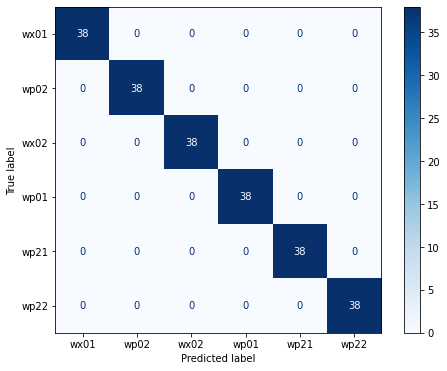

In [15]:
disp = ConfusionMatrixDisplay(confusion_matrix=avg_conf,
                              display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)

In this last cell we can observe the confusion matrix of the classification results, averaged over the 10 folds. As we can see, it is nearly a diagonal matrix which means there were no mismatches, and that goes accordingly to the 100% accuracy achieved.

---